In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #visualisation
%load_ext autoreload
%autoreload 2

## Generate predictions and save ouput in csv format for submission:

## Steps:
1. Run and tune all methods on the full unchanged dataset and compare them
-- Use Grid Search for fitting ployn ...
2. Do feature selection, data cleaning, and so on - compare improvements
-- Do visualization

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from implementations import *
from helpers_perso import *
from plots import *

### Load unchanged dataset

In [3]:
from proj1_helpers import *
from zipfile import ZipFile

DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
with ZipFile('../data/train.csv.zip', 'r') as zip:
    zip.extractall('../data')
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

Standardize

In [4]:
tX, mean_X, std_X = standardize(tX)

Change labels which are -1 to 0

In [5]:
# Binary problem change the labels in y 
print("Example", y[0:10])
y = np.where(y == -1, 0, y)
print("Example after", y[0:10])

Example [ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.]
Example after [1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]


# Training with the unchanged dataset

### Create Train, Validate and a Test Set

In [6]:
# from train take 20% as a validation set and 10% as a test set
tX_train, tX_val, y_train, y_val = split_data(tX, y, ratio=0.8, seed=1)
print("Size of the train set: {}. Size of the validation set: {}.".format(tX_train.shape[0], tX_val.shape[0]))

Size of the train set: 200000. Size of the validation set: 50000.


In [7]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
with ZipFile('../data/test.csv.zip', 'r') as zip:
    zip.extractall('../data')
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
print("Size of the test set: {}.".format(tX_test.shape[0]))
# Standardize
tX_test, mean_X_test, std_X_test = standardize(tX_test)

Size of the test set: 568238.


### Training with least squares gradient descent

In step: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 140.32it/s]


TP: 17176, TN: 0, FP: 32763, FN: 0


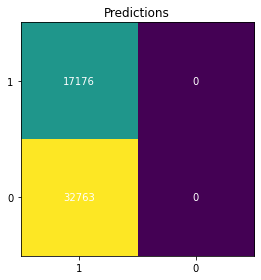

Recall: 1.0
Precision: 0.34393960631971005
F_2 score: 0.723852228955775
Accruacy: 0.34393960631971005
MSE loss 0.16563070800558094
Prediction example [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
# Training on the learning dataset

#train_loss, weights = logistic_regression(y, tX, initial_w=[1] * tX.shape[1], max_iter=5000, gamma=0.5)
train_loss, weights = least_squares_GD(y_train, tX_train, initial_w=[0] * tX_train.shape[1], max_iters=50, gamma=0.0001)
# Estimating the predictions on the validation set
# pred_val = tX_val@weights
pred_val = predict_labels(weights, tX_val) 
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the mse resulting from the validation set
### odd: just predicted now again
mse_test = compute_loss_mse(y_val, tX_val, weights)
print("MSE loss", mse_test)
print("Prediction example", pred_val[:10])

In [ ]:
print(weights)

In [ ]:
#from helpers_perso import standardize
#Let's see the dimension of the input and output
#tx, mean_x, std_x = standardize(tX)
#tX.shape, mean_x, std_x, y.shape

### Exploring the data

In [ ]:
#Exploring y
sns.countplot(x = y, palette = "bwr") 
plt.xlabel("Output y values")
plt.show()

We can remark that the data are not well balanced for the output and this can cause some trouble.

In [ ]:
fig = plt.figure()
print(tX.shape[1])
number_features = tX.shape[1]
for i in range(0, number_features):
    ax = fig.add_subplot(10, 3, i+1)
    #remove useless values
    tX_tmp = tX[:, i]
    tX_tmp = tX_tmp[tX_tmp > -999]
    plt.boxplot(tX_tmp)
    plt.xlabel("Feature " + str(i))
fig.set_size_inches(20, 100)

In [ ]:
fig = plt.figure()
print(tX.shape[1])
number_features = tX.shape[1]
for i in range(0, number_features):
    ax = fig.add_subplot(10, 3, i+1)
    #remove useless values
    tX_tmp = tX[:, i]
    tX_tmp = tX_tmp[tX_tmp > -999]
    ax.scatter(tX_tmp, tX_tmp, marker= "*", color= "r")
    ax.set_xlabel("Feature " + str(i))
    ax.set_ylabel("Feature " + str(i))
fig.set_size_inches(20, 40)

### Interpretation

Thoses graphs shows the distribution of the features. 
We can see directly that a feature is categorical :
- Feature with 4 categories : 22

For the other features, we can see that only a few of them seems well distributed whereas the other have some outliers :
- Features with Outliers : 0, 1, 2, 3, 5, 8, 9, 10, 13, 16, 19, 21, 26, 29



# Feature processing 

Feature processing : Cleaning the dataset by removing useless features and values, combining others, finding better representations of the features to feed your model, scaling the features, and so on. Check this article
on feature engineering: 

http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

## Removing useless features

In [ ]:
tX
tX.shape

In [ ]:
# Removing useless features

# We begin by removing all the line with a PRI_jet_all_pt equal to 0
#print(tX.shape, y.shape, ids.shape)
#line_array = np.int_([])
#for i in range (tX.shape[0]):
#    if tX[i, 29] == 0. :
#        line_array = np.append(line_array, i)
#tX = np.delete(tX, line_array, axis=0)
#y = np.delete(y, line_array, axis=0)
#ids = np.delete(ids, line_array, axis=0) 
#tX = tX[np.where(tX[:, 29] != 0.)]
#print(tX[:15,:])
#tX.shape, y.shape, ids.shape

In [ ]:
#Useless feature with

In [ ]:
# Removing rows with missing values (Nan)

#tX = tX[~np.isnan(tX).any(axis=1)]
#print(tX[:15,:])
#tX.shape

In [ ]:
#Correlation between features
linear_relation = []
mat = np.corrcoef(tX, rowvar = 0)
#print(mat)
for i in range(mat.shape[0]):
    for j in range(0, i):
        if mat[i, j] > 0.999:
            linear_relation.append((j, i, mat[i, j]))
linear_relation

In [ ]:
from math import *
#Visualization for the linear relation between feature
fig = plt.figure()
k = 1
for (i, j, r) in linear_relation : 
    ax = fig.add_subplot((len(linear_relation)//3)+1, 3, k)
    #we keep useless values to see the relation between features when one is -999
    ax.scatter(tX[:,i], tX[:,j], marker= "*", color= "r")
    ax.set_xlabel("Feature " + str(i))
    ax.set_ylabel("Feature " + str(j))
    k += 1
fig.set_size_inches(20, 40)

In [ ]:
#As they are corrolated, we can remove one of the features in the final input 
column_array = np.int_([])
for (i, j, r) in linear_relation :
    if not (i in column_array) :
        column_array = np.append(column_array, i)
    else :
        if not (j in column_array) :
            column_array = np.append(column_array, j)
tX = np.delete(tX, column_array, axis=1)
tX.shape

We will now work only with 22 features

### Corrolation with prediction :

In [ ]:
fig = plt.figure(figsize = (20, 25))
j = 0

#Constructing a new matrice for esier plot
y_reshaped = y.reshape(y.shape[0], 1)
mat = np.concatenate((y_reshaped, tX), axis=1)

#print (mat)
#print(mat_one)
    
#print(np.where(mat[:, 0] == -1.))
#print(mat[np.where(mat[:, 0] == -1.), 2])
for i in range(1, mat.shape[1]):
    plt.subplot(6, 4, j+1)
    j += 1
    mat_minus_one = mat[np.where(mat[:, 0] == -1.), i].flatten()
    mat_one = mat[np.where(mat[:, 0] == 1.), i].flatten()
    plt.hist(mat_minus_one[np.where(mat_minus_one != -999.)], bins= 50, color='g', label = 'background', alpha=0.5)
    plt.hist(mat_one[np.where(mat_one != -999.)], bins=50, color='r', label = 'Higgs Boson', alpha=0.5)
    plt.legend(loc='best')
fig.suptitle('Features analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
#Corrolation of features with the prediction
tX_y_relation = []
mat = np.corrcoef(tX, y, rowvar = 0)
print(mat)
for i in range(mat.shape[0]):
    for j in range(0, i):
        if mat[i, j] > 0.999:
            tX_y_relation.append((j, i, mat[i, j]))
print(tX_y_relation)
for (i, j, r) in tX_y_relation : 
    ax = fig.add_subplot((len(tX_y_relation)//3)+1, 3, k)
    #we keep useless values to see the relation between features when one is -999
    ax.scatter(tX[:,i], tX[:,j], marker= "*", color= "r")
    ax.set_xlabel("Feature " + str(i))
    ax.set_ylabel("Feature " + str(j))
    k += 1
fig.set_size_inches(20, 40)

## Do your thing crazy machine learning thing here :) ...

### Trainer

In [ ]:
# testing trainer with validation
loss, weights = trainer_val(y_val, tX_val, 10, least_squares_GD, compute_loss_mse, y_train, tX_train, [0] * tX_train.shape[1], 55, 0.0001)

In [ ]:
# Estimating the predictions on the validation set
# pred_val = tX_val@weights
pred_val = predict_labels(weights, tX_val) #### using -1!!!
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the mse resulting from the validation set
### odd: just predicted now again
mse_test = compute_loss_mse(y_val, tX_val, weights)
print("MSE loss", mse_test)
print("Prediction example", pred_val[:10])

### least_squares_SGD
### least_squares
### ridge_regression
### logistic_regression
### reg_logistic_regression

# Training with the filtered dataset

In [ ]:
OUTPUT_PATH = '../data/output.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)